In [1]:
import numpy as np
from PIB import PIB
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
root = './data/Train/chb10'
cclass_a = 'Interictal'
cclass_b = 'Preictal'

interictal_files_training = ['chb10_01_interictal.npy', 'chb10_02_interictal.npy']
interictal_file_validation = 'chb10_03_interictal.npy'

preictal_files_training = ['chb10_12_preictal.npy', 'chb10_20_preictal.npy']
preictal_file_validation = 'chb10_27_preictal.npy'

In [3]:
bands = [(0.1, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'), (12, 30, 'Beta'), (30, 70, 'Low Gamma'), (70, 127.9, 'High Gamma')]
band_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Low Gamma', 'High Gamma']
pib = PIB(fs=256, sliding_window=35, bands=bands, band_names=band_names, fft_window='hann', fft_window_duration=20)
print('Neural Rhythms:')
bands

Neural Rhythms:


[(0.1, 4, 'Delta'),
 (4, 8, 'Theta'),
 (8, 12, 'Alpha'),
 (12, 30, 'Beta'),
 (30, 70, 'Low Gamma'),
 (70, 127.9, 'High Gamma')]

In [4]:
# generate TRAIN AR features
interictal_train_feature_list = []
preictal_train_feature_list = []
for i in range(2):
    # interictal
    filepath = root + '/' + cclass_a + '/' + interictal_files_training[i]
    data = np.load(filepath)
    features = pib.spin(sig=data)
    interictal_train_feature_list.append(features)
    # preictal
    filepath = root + '/' + cclass_b + '/' + preictal_files_training[i]
    data = np.load(filepath)
    features = pib.spin(sig=data)
    preictal_train_feature_list.append(features)
del filepath, data, features

100%|██████████| 221441/221441 [00:04<00:00, 48419.90it/s]


In [5]:
# generate VALIDATION AR features
# interictal
filepath = root + '/' + cclass_a + '/' + interictal_file_validation
data = np.load(filepath)
interictal_val = pib.spin(sig=data)
interictal_val = interictal_val
# preictal
filepath = root + '/' + cclass_b + '/' + preictal_file_validation
data = np.load(filepath)
preictal_val = pib.spin(sig=data)
preictal_val = preictal_val
del filepath, data

100%|██████████| 221441/221441 [00:03<00:00, 64453.85it/s]


In [6]:
print(interictal_train_feature_list[0].shape, preictal_train_feature_list[0].shape)
print(interictal_val.shape, preictal_val.shape)

(575, 6) (575, 6)
(575, 6) (575, 6)


In [7]:
interictal_train = np.vstack(interictal_train_feature_list)
preictal_train = np.vstack(preictal_train_feature_list)
print(interictal_train.shape, preictal_train.shape)

(1150, 6) (1150, 6)


In [8]:
# generate TRAIN labels
interictal_train_targets = -1 * np.ones(interictal_train.shape[0]) # interictal samples are labelled -1
preictal_train_targets = np.ones(preictal_train.shape[0]) # preictal samples are labelled 1
print(interictal_train_targets.shape, preictal_train_targets.shape)

(1150,) (1150,)


In [9]:
# generate VALIDATION labels
interictal_val_targets = -1 * np.ones(interictal_val.shape[0])
preictal_val_targets = np.ones(preictal_val.shape[0])
print(interictal_val_targets.shape, preictal_val_targets.shape)

(575,) (575,)


In [10]:
X = np.vstack((interictal_train, interictal_val, preictal_train, preictal_val))
y = np.hstack((interictal_train_targets, interictal_val_targets, preictal_train_targets, preictal_val_targets))
print(X.shape, y.shape)

(3450, 6) (3450,)


In [11]:
df = pd.DataFrame(X, columns=band_names)
df['Period'] = y
di = {-1: "Interictal", 1: "Preictal"} # map numeric target to string label
df.replace({"Period": di}, inplace=True)
df.head()

,Delta,Theta,Alpha,Beta,Low Gamma,High Gamma,Period
0,0.859480,0.090321,0.008140,0.023769,0.014628,0.003662,Interictal
1,0.854619,0.117165,0.016630,0.007480,0.002646,0.001459,Interictal
2,0.835604,0.137757,0.012837,0.010464,0.002984,0.000354,Interictal
3,0.908768,0.080062,0.007336,0.002987,0.000727,0.000121,Interictal
4,0.857712,0.104944,0.009820,0.017415,0.009117,0.000992,Interictal


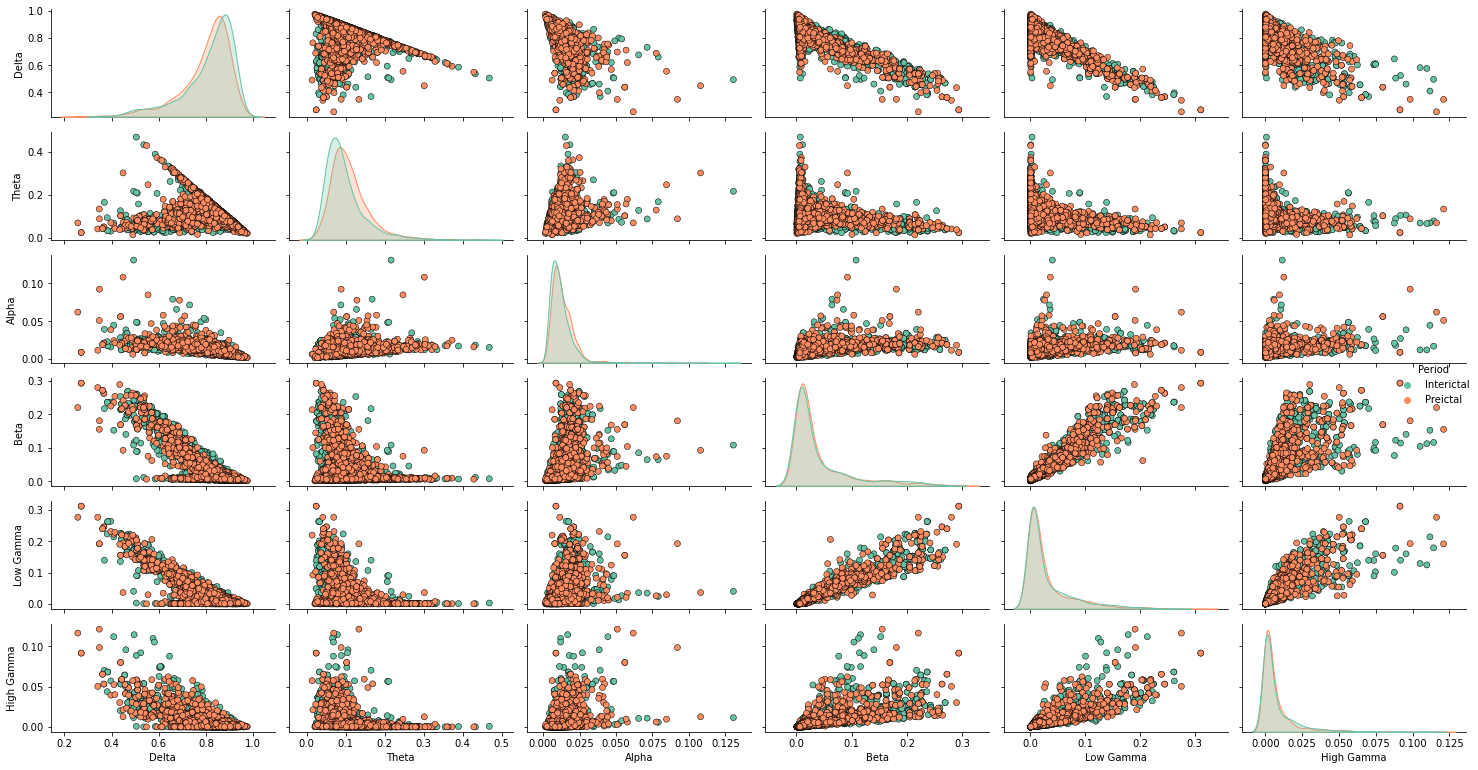

In [12]:
palette = sns.color_palette("Set2", n_colors=2)
sns.pairplot(df, hue='Period', height=1.8, aspect=1.8, palette=palette,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))
plt.tight_layout()
# plt.savefig('../figures/feature_extraction/chb001/PIB_sample_distr.pdf')
plt.show()

In [13]:
# shuffle and split into TRAIN and VAL sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, X_val.shape)

(2311, 6) (1139, 6)


[[467 116]
 [392 164]]
              precision    recall  f1-score   support

        -1.0       0.54      0.80      0.65       583
         1.0       0.59      0.29      0.39       556

    accuracy                           0.55      1139
   macro avg       0.56      0.55      0.52      1139
weighted avg       0.56      0.55      0.52      1139



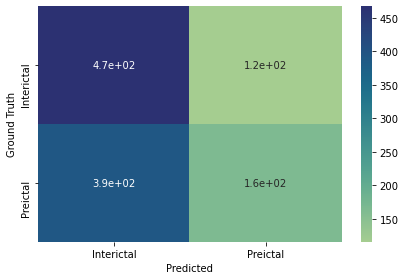

In [14]:
# model training
svc = SVC(kernel='linear', class_weight='balanced')
svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
confuse = confusion_matrix(y_val, y_pred)

palette = sns.color_palette('crest', as_cmap=True)
ax = sns.heatmap(confuse, annot=True, cmap=palette)
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.tight_layout()

[[398 185]
 [292 264]]
              precision    recall  f1-score   support

        -1.0       0.58      0.68      0.63       583
         1.0       0.59      0.47      0.53       556

    accuracy                           0.58      1139
   macro avg       0.58      0.58      0.58      1139
weighted avg       0.58      0.58      0.58      1139



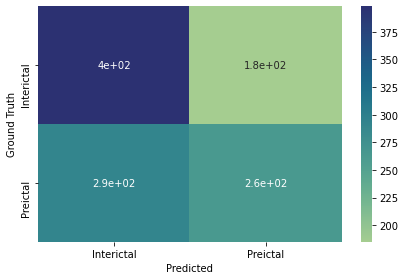

In [15]:
# model training
svc = SVC(kernel='rbf', class_weight='balanced')
svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
confuse = confusion_matrix(y_val, y_pred)

palette = sns.color_palette('crest', as_cmap=True)
ax = sns.heatmap(confuse, annot=True, cmap=palette)
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.tight_layout()

[[348 235]
 [242 314]]
              precision    recall  f1-score   support

        -1.0       0.59      0.60      0.59       583
         1.0       0.57      0.56      0.57       556

    accuracy                           0.58      1139
   macro avg       0.58      0.58      0.58      1139
weighted avg       0.58      0.58      0.58      1139



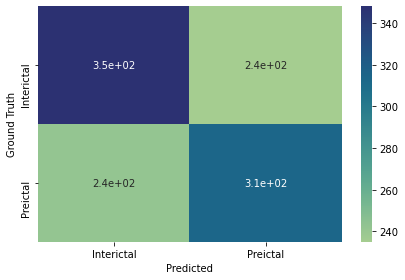

In [16]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
confuse = confusion_matrix(y_val, y_pred)

palette = sns.color_palette('crest', as_cmap=True)
ax = sns.heatmap(confuse, annot=True, cmap=palette)
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.tight_layout()